<a href="https://colab.research.google.com/github/RealYarik/ard/blob/main/ds4_04_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithms for Big Data - Exercise 5
This lecture is focused in more advanced example of the CNN - Variational Autoencoder (VAE). 

We will use the MNIST dataset but other may be used as well.


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_05.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_05.ipynb)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
import scipy

tf.version.VERSION

'2.3.0'

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i].reshape(28,28), cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i]])
    plt.show()

In [ ]:
class Mish(keras.layers.Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': Mish(mish)})

# We will use MNIST dataset in this example as in the previous ones

In [ ]:
# mnist is the basic dataset for image classifaction
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x.reshape(*train_x.shape, 1)
test_x = test_x.reshape(*test_x.shape, 1)

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 28x28 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = [str(x) for x in range(10)]
class_count = len(class_names)
print('Class count:', class_count, class_names)


11493376/11490434 [==============================] - 0s 0us/step
Train data shape:  (48000, 28, 28, 1) (48000,)
Validation data shape:  (12000, 28, 28, 1) (12000,)
Test data shape:   (10000, 28, 28, 1) (10000,)
Class count: 10 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# Task for the lecture
- Create another VAE model which will work with human faces
- We will use dataset Labeled Faces in the Wild [see this](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)
- You can use same model architecture as in the lecture model for MNIST, just the input shape differes
- Train models with 2 and 200 latent dimensions vectors
- Reconstruct faces and generate some new
- Can you see any difference in images reconstructed/generated with latent vectors with 2 or 200 dimensions?
    - Write down your opinion to the bottom of the notebook!
        
## Beware that faces are more complex than MNIST digits
## Output is very similar to blurry images at the link above
## The output will be blurry as hell and usually only remotely remind you of original face
 - Generated faces are kinda scary so they would make great avatars for 3D shooters from the early 90s  :-)

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=10)

# Original shape is 64*47 

In [ ]:
lfw_people.images.shape

(4324, 62, 47)

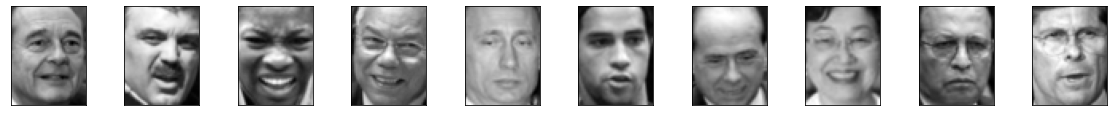

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(lfw_people.images[i].reshape(62, 47))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
lfw_people = lfw_people.images.reshape(-1, 62, 47, 1)

In [ ]:
X_train, X_test = train_test_split(lfw_people, test_size=0.1, random_state=13)

In [ ]:
X_train.shape

(3891, 62, 47, 1)

In [ ]:
X_test.shape

(433, 62, 47, 1)

In [ ]:
import cv2
size = 64

train_x_res = np.array([cv2.resize(x, (size, size)) for x in X_train])
test_x_res = np.array([cv2.resize(x, (size, size)) for x in X_test])
train_x_r = train_x_res.reshape(-1, size, size, 1).astype('float32')/255.0
test_x_r = test_x_res.reshape(-1, size, size, 1).astype('float32')/255.0

In [ ]:
input_shape = train_x_r.shape[1:]

In [ ]:
input_shape

(64, 64, 1)

In [ ]:
def total_loss_closure(mean_mu, log_var):
    def r_loss(y_true, y_pred):
      return keras.backend.mean(keras.backend.square(y_true - y_pred), axis=[0, 1])

    def kl_loss(y_true, y_pred):
      kl_loss =  -0.5 * keras.backend.sum(1 + log_var - keras.backend.square(mean_mu) - keras.backend.exp(log_var), axis = 1)
      return kl_loss

    def loss(y_true, y_pred):
      LOSS_FACTOR = 10000
      return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    return loss

# VAE with 2 dims, vae_model is your VAE model

In [ ]:
latent_dim = 2

In [ ]:
encoder_input = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(1, (3,3), strides=1, padding='same')(encoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(32, (3,3), strides=1, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(64, (3,3), strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(64, (3,3), strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(64, (3,3), strides=1, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)

before_flatten_shape = keras.backend.int_shape(x)[1:]
print(before_flatten_shape)

x = keras.layers.Flatten()(x)
mean_mu = keras.layers.Dense(latent_dim, name='mean_mu')(x)
log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
encoder_output = keras.layers.Lambda(sampling)([mean_mu, log_var])

enc_model = keras.Model(encoder_input, encoder_output)
enc_model.summary()

(16, 16, 64)
Model: "functional_155"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 64, 64, 1)    10          input_31[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 64, 64, 1)    4           conv2d_93[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_46 (LeakyReLU)      (None, 64, 64, 1)    0           batch_normalization_94[0][0]     
________________________________________________________________________

In [ ]:
decoder_input = keras.layers.Input(shape = (latent_dim,) , name = 'decoder_input')
x = keras.layers.Dense(np.prod(before_flatten_shape))(decoder_input)
x = keras.layers.Reshape(before_flatten_shape)(x)
x = keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')(x)
decoder_output = x

dec_model = keras.Model(decoder_input, decoder_output)
dec_model.summary()

Model: "functional_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_34 (Dense)             (None, 16384)             49152     
_________________________________________________________________
reshape_34 (Reshape)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_77 (Conv2DT (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_transpose_78 (Conv2DT (None, 64, 64, 1)         1153      
Total params: 124,161
Trainable params: 124,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vae_input = encoder_input

vae_output = dec_model(encoder_output)

vae_model = keras.Model(vae_input, vae_output)

Train on 3501 samples, validate on 390 samples
Epoch 1/20
3501/3501 [==============================] - 5s 1ms/sample - loss: 306.7929 - val_loss: 284.6585
Epoch 2/20
3501/3501 [==============================] - 2s 458us/sample - loss: 197.2483 - val_loss: 278.8034
Epoch 3/20
3501/3501 [==============================] - 2s 443us/sample - loss: 173.8722 - val_loss: 279.7731
Epoch 4/20
3501/3501 [==============================] - 2s 453us/sample - loss: 175.1710 - val_loss: 276.7201
Epoch 5/20
3501/3501 [==============================] - 2s 461us/sample - loss: 171.3193 - val_loss: 281.1315
Epoch 6/20
3501/3501 [==============================] - 2s 453us/sample - loss: 170.6371 - val_loss: 288.6633
Epoch 7/20
3501/3501 [==============================] - 2s 452us/sample - loss: 169.7870 - val_loss: 275.0688
Epoch 8/20
3501/3501 [==============================] - 2s 454us/sample - loss: 168.9357 - val_loss: 283.0296
Epoch 9/20
3501/3501 [==============================] - 2s 451us/sample - l

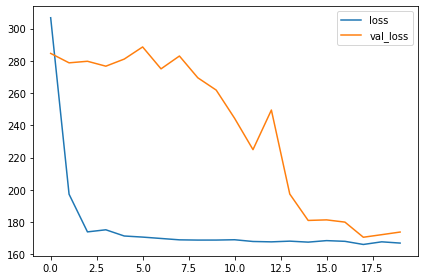

In [ ]:
vae_model.compile(optimizer='adam', loss = total_loss_closure(mean_mu, log_var))
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, restore_best_weights=True)

batch_size = 128
epochs = 20
history = vae_model.fit(train_x_r, train_x_r, validation_split=0.1, callbacks=[es], epochs=epochs, batch_size=batch_size)
show_history(history)

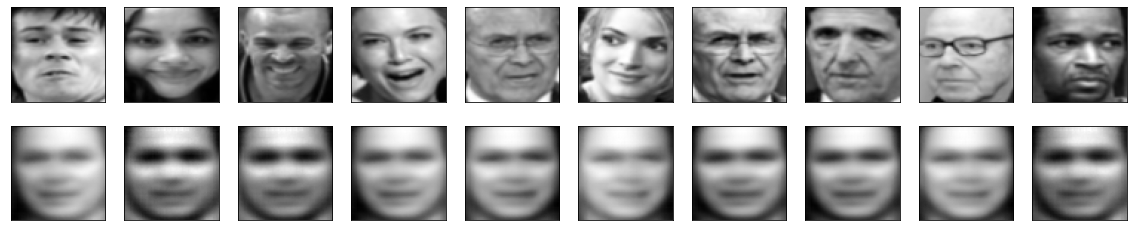

In [ ]:
predicted = vae_model.predict(test_x_r)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_x_r[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(predicted[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

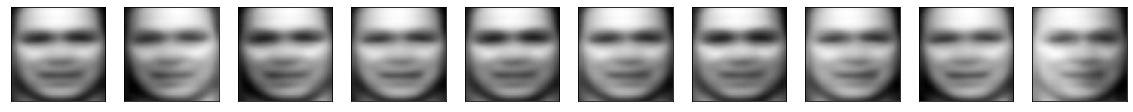

In [ ]:
n = 10
reconst_images = dec_model.predict(np.random.normal(0,1,size=(n,latent_dim)))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(reconst_images[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# VAE with 200 dims, vae_model is your VAE model

In [ ]:
latent_dim = 200

In [ ]:
encoder_input = keras.layers.Input(shape=input_shape)
encoder_input = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(1, (3,3), strides=1, padding='same')(encoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(32, (3,3), strides=1, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(64, (3,3), strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(64, (3,3), strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(64, (3,3), strides=1, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)

before_flatten_shape = keras.backend.int_shape(x)[1:]
print(before_flatten_shape)

x = keras.layers.Flatten()(x)
mean_mu = keras.layers.Dense(latent_dim, name='mean_mu')(x)
log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
encoder_output = keras.layers.Lambda(sampling)([mean_mu, log_var])

enc_model = keras.Model(encoder_input, encoder_output)
enc_model.summary()

(16, 16, 64)
Model: "functional_161"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 64, 64, 1)    10          input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 64, 64, 1)    4           conv2d_98[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_51 (LeakyReLU)      (None, 64, 64, 1)    0           batch_normalization_99[0][0]     
________________________________________________________________________

In [ ]:
decoder_input = keras.layers.Input(shape = (latent_dim,) , name = 'decoder_input')
x = keras.layers.Dense(np.prod(before_flatten_shape))(decoder_input)
x = keras.layers.Reshape(before_flatten_shape)(x)
x = keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')(x)
decoder_output = x

dec_model = keras.Model(decoder_input, decoder_output)
dec_model.summary()

Model: "functional_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense_35 (Dense)             (None, 16384)             3293184   
_________________________________________________________________
reshape_35 (Reshape)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_79 (Conv2DT (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_transpose_80 (Conv2DT (None, 64, 64, 1)         1153      
Total params: 3,368,193
Trainable params: 3,368,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vae_input = encoder_input

vae_output = dec_model(encoder_output)

vae_model = keras.Model(vae_input, vae_output)

Train on 3501 samples, validate on 390 samples
Epoch 1/20
3501/3501 [==============================] - 5s 1ms/sample - loss: 502.5167 - val_loss: 422.7982
Epoch 2/20
3501/3501 [==============================] - 2s 563us/sample - loss: 213.6377 - val_loss: 428.6796
Epoch 3/20
3501/3501 [==============================] - 2s 539us/sample - loss: 178.5207 - val_loss: 462.9886
Epoch 4/20
3501/3501 [==============================] - 2s 551us/sample - loss: 154.3210 - val_loss: 417.8278
Epoch 5/20
3501/3501 [==============================] - 2s 555us/sample - loss: 153.0267 - val_loss: 351.5315
Epoch 6/20
3501/3501 [==============================] - 2s 564us/sample - loss: 141.9910 - val_loss: 316.1084
Epoch 7/20
3501/3501 [==============================] - 2s 548us/sample - loss: 131.8154 - val_loss: 259.9805
Epoch 8/20
3501/3501 [==============================] - 2s 562us/sample - loss: 127.3940 - val_loss: 204.0836
Epoch 9/20
3501/3501 [==============================] - 2s 548us/sample - l

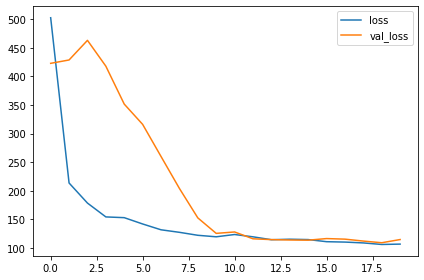

In [ ]:
vae_model.compile(optimizer='adam', loss = total_loss_closure(mean_mu, log_var))
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, restore_best_weights=True)

batch_size = 64
epochs = 20
history = vae_model.fit(train_x_r, train_x_r, validation_split=0.1, callbacks=[es], epochs=epochs, batch_size=batch_size)
show_history(history)

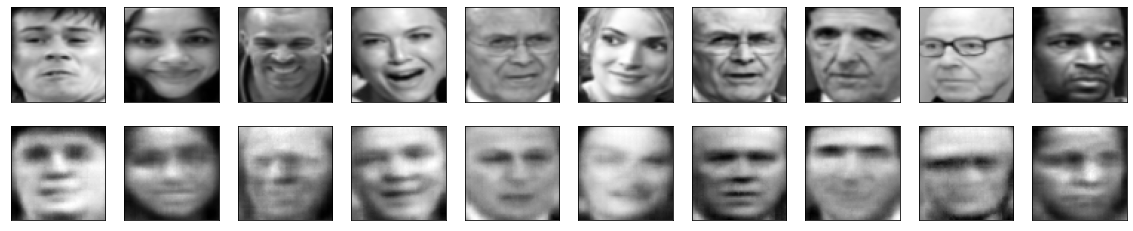

In [ ]:
predicted = vae_model.predict(test_x_r)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_x_r[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(predicted[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

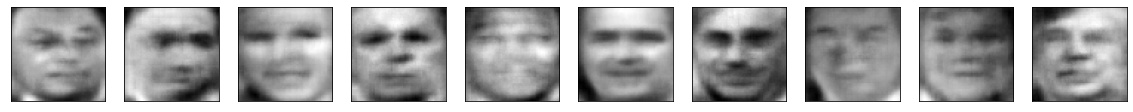

In [ ]:
n = 10
reconst_images = dec_model.predict(np.random.normal(0,1,size=(n,latent_dim)))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(reconst_images[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  

## Can you see any difference in images reconstructed/generated with latent vectors with 2 or 200 dimensions?

In [ ]:
# Write your opinion on the differences here!

An image with 2 dims has a more blurry presentation than with 200 dims.
In addition, emotions with 200 dims have a clearer color(we can see this above in the images).Therefore, for this task, it is better to use 200 dims